Grid Search Analysis
===

This integrated notebook analysis all grid search results in one shot.

Compares the results of the grid search per dataset. And spits out the best one...


In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib import cm


import json
import codecs
import os
from os import path

In [7]:
# set to false if the full csv already exists
CONVERT_FROM_RAW=True

In [8]:
basepath = os.path.normpath("C:\\Users\\hatieke\\temp")

In [9]:
basepath = os.path.normpath("C:\\Users\\hatieke\\.ukpsummarizer\\results\\grid_search")

In [10]:
basepath = os.path.normpath("C:\\Users\\hatieke\\Desktop\\scores_grid_2017-09-15")

In [11]:
def new_parser(dir):
    for root, dirs, files in os.walk(dir):
        for f in files:
            if f.startswith("result-") and f.endswith(".json"):
                fn = os.path.join(root, f)
                fsize = os.path.getsize(fn)
                if fsize > 0:
                    with open(fn) as fp:
                        data = json.load(fp)
                        data["parent_directory"] = root
                        yield data
                        

In [12]:
def parse_single_result_per_iteration_into_rows(obj):
    config = obj[u'config_feedbackstore']

    results = [i for i in obj["result_rougescores"]]
    for res in results:
        #print "before: it:" , res["iteration"] , "acc:" , len(res[u'accepted']) ,"rej:" , len(res["rejected"])
        if res["iteration"] == 0 and len(res[u'accepted']) == 0 and len(res["rejected"]) == 0:
            # do nothing
            minusone=-1
        else: 
            minusone=0
        iteration = res["iteration"] + minusone
        
        # this reduces the iteration-counter for the inital summary, i.e. the one, where we left of.
        #        res["iteration"] = res["iteration"]+minusone
        #print "after : it:" , iteration , "acc:" , len(res[u'accepted']) ,"rej:" , len(res["rejected"])

        accept_count = res["accept_count"]
        reject_count = res["reject_count"]

        total_accept = sum([1 for i in obj[u'log_feedbacks'] if i["value"] == 'accept' and i["iteration"] < iteration])
        total_reject = sum([1 for i in obj[u'log_feedbacks'] if i["value"] != 'accept' and i["iteration"] < iteration])
        total_feedback = total_accept + total_reject

        #iteration = res["iteration"]
        r1 =  res[u'ROUGE-1 R score']
        r2 =  res[u'ROUGE-2 R score']
        r4 =  res[u'ROUGE-SU* R score']

        classtype = config.get(u'type')
        cut_off_threshold = config.get(u'cut_off_threshold')
        iterations_accept = config.get(u'iterations_accept')
        iterations_reject = config.get(u'iterations_reject')
        propagation_abort_threshold = config.get(u'propagation_abort_threshold')
        mass_accept = config.get(u'mass_accept')
        mass_reject = config.get(u'mass_reject')
        window_size = config.get(u'N')
        factor_reject = config.get(u"multiplier_reject")
        factor_accept = config.get(u"multiplier_accept")
        cutoff = config.get(u"cut_off_threshold", config.get("cutoff_threshold"))

        runid = obj.get("config_run_id")
        word2vec = obj.get("config_wordembeddings")

        parse_type = obj.get("config_parse_type")
        if parse_type is None or parse_type.lower() is "None".lower():
            parse_type = "ngrams"

        oracle_type = obj.get("config_oracle_type", "accept")

        ub = obj.get("model_rougescores", {})
        ub_r1 = ub.get("ROUGE-1 R score", -1)
        ub_r2 = ub.get("ROUGE-2 R score", -1)
        ub_r4 = ub.get("ROUGE-SU* R score", -1)

        yield {
            "accept" : total_accept,
            "reject": total_reject,
            "accept_new": accept_count,
            "reject_new": reject_count,
            "feedback_new": accept_count+reject_count,
            "total_feedback": total_feedback,
            "ref_summary": str([item["name"] for item in obj[u'models']]),
            "cfg": json.dumps(config),
            "num_iterations": iteration,
            "r1": r1,
            "r2": r2,
            "r4": r4,
            "oracle": oracle_type,
            "classtype": classtype,
            "iterations_accept":iterations_accept,
            "iterations_reject": iterations_reject,
            "propagation_abort_threshold": propagation_abort_threshold,
            "mass_accept" : mass_accept,
            "mass_reject" : mass_reject,
            "window_size": window_size,
            "multiplier_reject": factor_reject,
            "multiplier_accept": factor_accept,
            "cutoff_threshold": cutoff,
            "run_id": runid,
            "ub_r1": ub_r1,
            "ub_r2": ub_r2,
            "ub_r4": ub_r4,
            "phrase_type": parse_type,
            "embeddings": word2vec,
            "size": 100,
            "max_iteration_count": len(results) - 1,
            "parent": obj.get("parent_directory", "unknown/parent/directory")
        }


In [13]:
odf = pd.DataFrame((r for i in new_parser(basepath) for r in parse_single_result_per_iteration_into_rows(i)))

In [14]:
list(odf.columns)

['accept',
 'accept_new',
 'cfg',
 'classtype',
 'cutoff_threshold',
 'embeddings',
 'feedback_new',
 'iterations_accept',
 'iterations_reject',
 'mass_accept',
 'mass_reject',
 'max_iteration_count',
 'multiplier_accept',
 'multiplier_reject',
 'num_iterations',
 'oracle',
 'parent',
 'phrase_type',
 'propagation_abort_threshold',
 'r1',
 'r2',
 'r4',
 'ref_summary',
 'reject',
 'reject_new',
 'run_id',
 'size',
 'total_feedback',
 'ub_r1',
 'ub_r2',
 'ub_r4',
 'window_size']

In [15]:
# remove real duplicates:
unidf = odf.drop_duplicates(["accept", "reject", "accept_new", "reject_new", "feedback_new", "total_feedback", "ref_summary", "cfg", "num_iterations", "r1", "r2", "r4", "oracle", "classtype", "iterations_accept", "iterations_reject", "propagation_abort_threshold", "mass_accept", "mass_reject", "window_size", "multiplier_reject", "multiplier_accept", "cutoff_threshold", "run_id", "ub_r1", "ub_r2", "ub_r4", "phrase_type", "embeddings", "size", "max_iteration_count"])

In [16]:
unidf.to_csv(path.join(basepath, "grid_search_dataframe_unique_rows.csv"))

In [17]:
# convert pojo into string
#df["cfg"] = df.apply(lambda x: json.dumps(x["cfg"]), axis=1)

In [18]:
unidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435863 entries, 0 to 435862
Data columns (total 32 columns):
accept                         435863 non-null int64
accept_new                     435863 non-null int64
cfg                            435863 non-null object
classtype                      435863 non-null object
cutoff_threshold               419126 non-null float64
embeddings                     435863 non-null object
feedback_new                   435863 non-null int64
iterations_accept              419126 non-null float64
iterations_reject              419126 non-null float64
mass_accept                    419126 non-null float64
mass_reject                    419126 non-null float64
max_iteration_count            435863 non-null int64
multiplier_accept              16568 non-null float64
multiplier_reject              16568 non-null float64
num_iterations                 435863 non-null int64
oracle                         435863 non-null object
parent                   

In [19]:
cdf = pd.DataFrame(unidf)
# Make categorical data although having numerical values, behave as categories
cdf["classtype"] = cdf["classtype"].astype("category")
cdf["cfg"] = cdf["cfg"].astype("category")
cdf["cutoff_threshold"] = cdf["cutoff_threshold"].astype("category")
cdf["embeddings"] = cdf["embeddings"].astype("category")
cdf["mass_accept"] = cdf["mass_accept"].astype("category")
cdf["mass_reject"] = cdf["mass_reject"].astype("category")
cdf["max_iteration_count"] = cdf["max_iteration_count"].astype("category")
cdf["multiplier_accept"] = cdf["multiplier_accept"].astype("category")
cdf["multiplier_reject"] = cdf["multiplier_reject"].astype("category")
cdf["oracle"] = cdf["oracle"].astype("category")
cdf["parent"] = cdf["parent"].astype("category")
cdf["phrase_type"] = cdf["phrase_type"].astype("category")
cdf["propagation_abort_threshold"] = cdf["propagation_abort_threshold"].astype("category")
cdf["size"] = cdf["size"].astype("category")
cdf["window_size"] = cdf["window_size"].astype("category")


In [20]:
odf = cdf

In [21]:
# throw away implausible results
ddf = odf.loc[odf.r2 >0].loc[odf.r1 > 0].loc[odf.r4 >0]

In [22]:
# only do this to exclude the initial value (-1)
ddf = ddf.loc[odf.num_iterations >= 0]

In [23]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390835 entries, 1 to 435862
Data columns (total 32 columns):
accept                         390835 non-null int64
accept_new                     390835 non-null int64
cfg                            390835 non-null category
classtype                      390835 non-null category
cutoff_threshold               376162 non-null category
embeddings                     390835 non-null category
feedback_new                   390835 non-null int64
iterations_accept              376162 non-null float64
iterations_reject              376162 non-null float64
mass_accept                    376162 non-null category
mass_reject                    376162 non-null category
max_iteration_count            390835 non-null category
multiplier_accept              14520 non-null category
multiplier_reject              14520 non-null category
num_iterations                 390835 non-null int64
oracle                         390835 non-null category
parent   

In [24]:
histogram_cols = list(set(list(cdf.columns)) - set(['run_id', "cfg", "parent", "max_iteration_count" , u'r1', "total_feedback", "feedback_new", u'r2', u'r4', u'ub_r1', u'ub_r2', u'ub_r4', u'accept', u'accept_new', u'cfg',u'reject', u'reject_new', ]))
for col in histogram_cols:
    if col == "run_id":
        continue
    print cdf.loc[:,[col, "run_id"]].groupby([col]).count()["run_id"]
    

multiplier_accept
0.00    1977
0.05    2098
0.25    2054
0.50    2089
1.00    2090
2.00    2052
4.00    2073
8.00    2135
Name: run_id, dtype: int64
window_size
2.0    4034
3.0    4155
4.0    4191
5.0    4188
Name: run_id, dtype: int64
embeddings
glove.6B.300d    435863
Name: run_id, dtype: int64
iterations_accept
128.0      144487
1024.0     144575
10000.0    130064
Name: run_id, dtype: int64
mass_reject
-4.0      8733
-1.0     95978
 0.0    107248
 1.0    102222
 4.0    104945
Name: run_id, dtype: int64
classtype
BaselineFeedbackStore                               169
SimpleNgramFeedbackGraph                          16568
WordEmbeddingGaussianFeedbackGraph                28869
WordEmbeddingRandomWalkDiffusionFeedbackGraph    390257
Name: run_id, dtype: int64
propagation_abort_threshold
0.10    97483
0.25    97521
0.50    97753
0.90    97500
Name: run_id, dtype: int64
mass_accept
-4.0      6663
-1.0     97436
 0.0    104759
 1.0    105052
 4.0    105216
Name: run_id, dtype: int64
ora

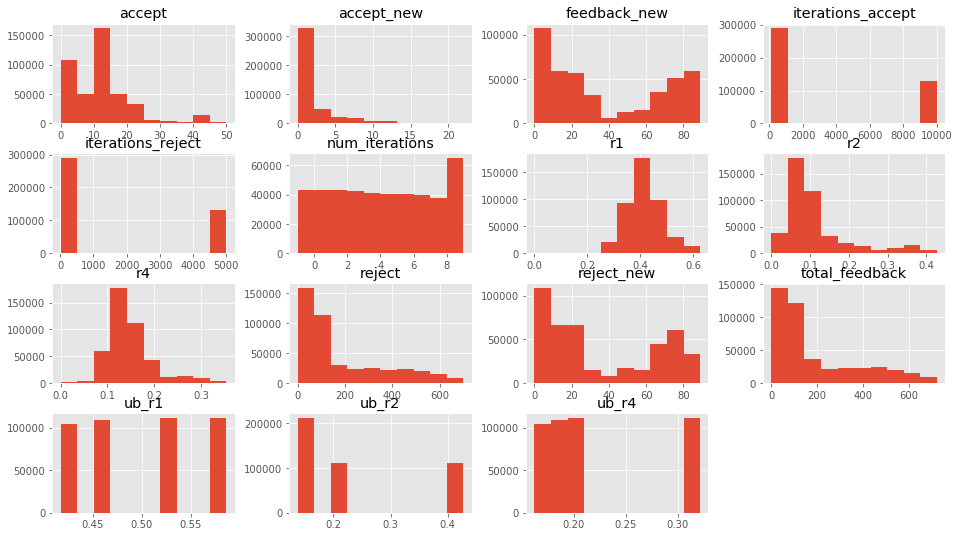

In [25]:
cdf.hist(figsize=(16,9))
plt.show()

Construction of a dataframe that fits the analysis needs
===

unabhängige Variablen, also Steuervariablen kann ich festlegen, die den Ausgang der Messung beeinflussen (in unbekannter Art). Im Dataframe sind das folgende Spalten:

* classtype
* cutoff_threshold
* iterations_accept
* iterations_reject
* mass_accept
* mass_reject
* multiplier_accept
* multiplier_reject
* propagation_abort_threshold
* ref_summary
* window_size
* num_iterations                 

Und folgende sind die abhängigen Variablen, also die Messvariablen, die quasi die Manifestation der Effekte. 

* accept
* num_iterations
* r1
* r2
* r4
* reject
* total_feedback

Es soll untersucht werden, welche Kombinationen unabhängiger Variablen die besten sind, also die baseline am weitesten übertreffen.

Dazu muss in jeder ref_summary-gruppe der wert der "baseline r2" als extra feld hinzugefügt werden und auch die differenz

Aus Rouge-2 baseline neue Spalten ableiten: als Delta und als Ratio 
---

In [60]:
ddf.head(1).transpose()

,1
accept,0
accept_new,3
cfg,"{""mass_reject"": -1.0, ""iterations_accept"": 102..."
classtype,WordEmbeddingRandomWalkDiffusionFeedbackGraph
cutoff_threshold,0.998
embeddings,glove.6B.300d
feedback_new,88
iterations_accept,1024
iterations_reject,64
mass_accept,4


In [26]:
baselines = ddf.classtype.str.contains("Baseline")


In [61]:
ddf.loc[baselines].groupby(["parent", "num_iterations","phrase_type"]).count()

accept  \
parent                                             num_iterations phrase_type           
C:\Users\hatieke\Desktop\scores_grid_2017-09-15... 0              None              8   
                                                                  parse             8   
                                                   1              None              8   
                                                                  parse             8   
                                                   2              None              8   
                                                                  parse             8   
                                                   3              None              8   
                                                                  parse             8   
                                                   4              None              8   
                                                                  parse             8   
                                                   5              None              8   
                                                                  parse             8   
                                                   6              None              8   
                                                                  parse             8   
                                                   7              None              8   
                                                                  parse             8   
                                                   8              None              6   
                                                                  parse             7   
                                                   9              None              6   
                                                                  parse             6   

                                                                               accept_new  \
parent                                             num_iterations phrase_type               
C:\Users\hatieke\Desktop\scores_grid_2017-09-15... 0              None                  8   
                                                                  parse                 8   
                                                   1              None                  8   
                                                                  parse                 8   
                                                   2              None                  8   
                                                                  parse                 8   
                                                   3              None                  8   
                                                                  parse                 8   
                                                   4              None                  8   
                                                                  parse                 8   
                                                   5              None                  8   
                                                                  parse                 8   
                                                   6              None                  8   
                                                                  parse                 8   
                                                   7              None                  8   
                                                                  parse                 8   
                                                   8              None                  6   
                                                                  parse                 7   
                                                   9              None                  6   
                                                                  parse                 6   

                                                                         

In [28]:
ddf.groupby("ref_summary").count()

,accept,accept_new,cfg,classtype,cutoff_threshold,embeddings,feedback_new,iterations_accept,iterations_reject,mass_accept,...,r4,reject,reject_new,run_id,size,total_feedback,ub_r1,ub_r2,ub_r4,window_size
ref_summary,,,,,,,,,,,,,,,,,,,,,
[u'D31043.M.100.T.D'],100099,100099,100099,100099,96153,100099,100099,96153,96153,96153,...,100099,100099,100099,100099,100099,100099,100099,100099,100099,3906
[u'D31043.M.100.T.F'],100337,100337,100337,100337,96665,100337,100337,96665,96665,96665,...,100337,100337,100337,100337,100337,100337,100337,100337,100337,3634
[u'D31043.M.100.T.G'],93174,93174,93174,93174,89653,93174,93174,89653,89653,89653,...,93174,93174,93174,93174,93174,93174,93174,93174,93174,3484
[u'D31043.M.100.T.H'],97225,97225,97225,97225,93691,97225,97225,93691,93691,93691,...,97225,97225,97225,97225,97225,97225,97225,97225,97225,3496


In [105]:
# find all baselines
baselines = ddf.classtype.str.contains("Baseline")

# throw away uninteresting columns
baseline_scores = ddf.loc[baselines].loc[:,["ref_summary","num_iterations","accept", "reject","r1","r2","r4","phrase_type"]]

In [106]:
baseline_scores.head(1).transpose()

,535
ref_summary,[u'D31043.M.100.T.H']
num_iterations,0
accept,0
reject,0
r1,0.37143
r2,0.06731
r4,0.10873
phrase_type,None


In [64]:
# rename important columns
baseline_scores.rename(columns={"r2":"r2bl", "accept": "acceptbl", "reject":"rejectbl"}, inplace=True)
# make sure, we have everything in there only once.
baseline_scores= baseline_scores.drop_duplicates(["ref_summary","num_iterations", "phrase_type"])
baseline_scores= baseline_scores.loc[baseline_scores.acceptbl > 0].loc[baseline_scores.rejectbl > 0]

In [100]:
baseline_scores.groupby(["ref_summary", "phrase_type"]).max()

num_iterations  acceptbl  rejectbl     r2bl
ref_summary           phrase_type                                             
[u'D31043.M.100.T.D'] None                      9        42       425  0.37864
                      parse                     9        15       108  0.31068
[u'D31043.M.100.T.F'] None                      9        19       550  0.15686
                      parse                     9        14       143  0.11765
[u'D31043.M.100.T.G'] None                      9        21       658  0.13725
                      parse                     9        15       132  0.10784
[u'D31043.M.100.T.H'] None                      9        23       614  0.13462
                      parse                     9        13       147  0.07692

In [67]:
baseline_scores

,ref_summary,num_iterations,acceptbl,rejectbl,r2bl,phrase_type
536,[u'D31043.M.100.T.H'],1,6,82,0.07692,None
537,[u'D31043.M.100.T.H'],2,11,160,0.03846,None
538,[u'D31043.M.100.T.H'],3,11,244,0.12500,None
539,[u'D31043.M.100.T.H'],4,18,316,0.13462,None
540,[u'D31043.M.100.T.H'],5,22,383,0.03846,None
541,[u'D31043.M.100.T.H'],6,22,460,0.07692,None
542,[u'D31043.M.100.T.H'],7,23,530,0.10577,None
543,[u'D31043.M.100.T.H'],8,23,570,0.09615,None
544,[u'D31043.M.100.T.H'],9,23,614,0.09615,None
7458,[u'D31043.M.100.T.G'],1,10,21,0.08824,parse


In [68]:
# merge df and baseline_scores, so that the r2bl score is now available in every run.
df= pd.merge(ddf, baseline_scores, on=["ref_summary", "num_iterations", "phrase_type"])

In [69]:
#df = df.sample(2000)

In [70]:
# add the delta of baseline and actual r2 as separate column
df["delta_r2bl_r2"] = df["r2bl"] - df["r2"]
df["ratio_r2_vs_r2bl"] = df["r2"] / df["r2bl"]

In [71]:
# add the delta and ratio of the upper bound r2 as separate columns:
df["delta_r2ub"] = df["ub_r2"] - df["r2"]
df["ratio_r2ub"] = df["r2"] / df["ub_r2"]
df["ratio_r2ub_vs_feedback"] = df["ratio_r2ub"] / df["total_feedback"]

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347795 entries, 0 to 347794
Data columns (total 40 columns):
accept                         347795 non-null int64
accept_new                     347795 non-null int64
cfg                            347795 non-null object
classtype                      347795 non-null object
cutoff_threshold               335186 non-null float64
embeddings                     347795 non-null object
feedback_new                   347795 non-null int64
iterations_accept              335186 non-null float64
iterations_reject              335186 non-null float64
mass_accept                    335186 non-null float64
mass_reject                    335186 non-null float64
max_iteration_count            347795 non-null int64
multiplier_accept              12472 non-null float64
multiplier_reject              12472 non-null float64
num_iterations                 347795 non-null int64
oracle                         347795 non-null object
parent                   

In [73]:
df.to_csv(path.join(basepath, "grid_search_df_with_r2ub_and_r2bl.csv"))

In [74]:
# restrict to the main topic
D31043 = df.loc[df.ref_summary.str.contains("D31043.M.100.T")]

In [ ]:
# restrict to the main topic
D30044 = df.loc[df.ref_summary.str.contains("D30044.M.100.T")]

Overall information
===

In [75]:
df.groupby(["phrase_type", "ref_summary"]).count()

accept  accept_new    cfg  classtype  \
phrase_type ref_summary                                                   
None        [u'D31043.M.100.T.D']   45499       45499  45499      45499   
            [u'D31043.M.100.T.F']   45543       45543  45543      45543   
            [u'D31043.M.100.T.G']   40720       40720  40720      40720   
            [u'D31043.M.100.T.H']   45246       45246  45246      45246   
parse       [u'D31043.M.100.T.D']   43842       43842  43842      43842   
            [u'D31043.M.100.T.F']   44033       44033  44033      44033   
            [u'D31043.M.100.T.G']   41689       41689  41689      41689   
            [u'D31043.M.100.T.H']   41223       41223  41223      41223   

                                   cutoff_threshold  embeddings  feedback_new  \
phrase_type ref_summary                                                         
None        [u'D31043.M.100.T.D']             42087       45499         45499   
            [u'D31043.M.100.T.F']             42403       45543         45543   
            [u'D31043.M.100.T.G']             37732       40720         40720   
            [u'D31043.M.100.T.H']             42246       45246         45246   
parse       [u'D31043.M.100.T.D']             43824       43842         43842   
            [u'D31043.M.100.T.F']             44017       44033         44033   
            [u'D31043.M.100.T.G']             41672       41689         41689   
            [u'D31043.M.100.T.H']             41205       41223         41223   

                                   iterations_accept  iterations_reject  \
phrase_type ref_summary                                                   
None        [u'D31043.M.100.T.D']              42087              42087   
            [u'D31043.M.100.T.F']              42403              42403   
            [u'D31043.M.100.T.G']              37732              37732   
            [u'D31043.M.100.T.H']              42246              42246   
parse       [u'D31043.M.100.T.D']              43824              43824   
            [u'D31043.M.100.T.F']              44017              44017   
            [u'D31043.M.100.T.G']              41672              41672   
            [u'D31043.M.100.T.H']              41205              41205   

                                   mass_accept           ...            ub_r4  \
phrase_type ref_summary                                  ...                    
None        [u'D31043.M.100.T.D']        42087           ...            45499   
            [u'D31043.M.100.T.F']        42403           ...            45543   
            [u'D31043.M.100.T.G']        37732           ...            40720   
            [u'D31043.M.100.T.H']        42246           ...            45246   
parse       [u'D31043.M.100.T.D']        43824           ...            43842   
            [u'D31043.M.100.T.F']        44017           ...            44033   
            [u'D31043.M.100.T.G']        41672           ...            41689   
            [u'D31043.M.100.T.H']        41205           ...            41223   

                                   window_size  acceptbl  rejectbl   r2bl  \
phrase_type ref_summary                                                     
None        [u'D31043.M.100.T.D']         3394     45499     45499  45499   
            [u'D31043.M.100.T.F']         3122     45543     45543  45543   
            [u'D31043.M.100.T.G']         2972     40720     40720  40720   
            [u'D31043.M.100.T.H']         2984     45246     45246  45246   
parse       [u'D31043.M.100.T.D']            0     43842     43842  43842   
            [u'D31043.M.100.T.F']            0     44033     44033  44033   
            [u'D31043.M.100.T.G']            0     41689     41689  41689   
            [u'D31043.M.100.T.H']            0     41223     41223  41223   

                                   delta_r2bl_r2  ratio_r2_vs_r2bl  \
phrase_type ref_summary                                              


In [76]:
df.groupby("ref_summary").count()

,accept,accept_new,cfg,classtype,cutoff_threshold,embeddings,feedback_new,iterations_accept,iterations_reject,mass_accept,...,ub_r4,window_size,acceptbl,rejectbl,r2bl,delta_r2bl_r2,ratio_r2_vs_r2bl,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
ref_summary,,,,,,,,,,,,,,,,,,,,,
[u'D31043.M.100.T.D'],89341,89341,89341,89341,85911,89341,89341,85911,85911,85911,...,89341,3394,89341,89341,89341,89341,89341,89341,89341,89341
[u'D31043.M.100.T.F'],89576,89576,89576,89576,86420,89576,89576,86420,86420,86420,...,89576,3122,89576,89576,89576,89576,89576,89576,89576,89576
[u'D31043.M.100.T.G'],82409,82409,82409,82409,79404,82409,82409,79404,79404,79404,...,82409,2972,82409,82409,82409,82409,82409,82409,82409,82409
[u'D31043.M.100.T.H'],86469,86469,86469,86469,83451,86469,86469,83451,83451,83451,...,86469,2984,86469,86469,86469,86469,86469,86469,86469,86469


What classtypes are there? And how many of each?

In [77]:
df.groupby("classtype").count()

,accept,accept_new,cfg,cutoff_threshold,embeddings,feedback_new,iterations_accept,iterations_reject,mass_accept,mass_reject,...,ub_r4,window_size,acceptbl,rejectbl,r2bl,delta_r2bl_r2,ratio_r2_vs_r2bl,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
classtype,,,,,,,,,,,,,,,,,,,,,
BaselineFeedbackStore,137,137,137,0,137,137,0,0,0,0,...,137,0,137,137,137,137,137,137,137,137
SimpleNgramFeedbackGraph,12472,12472,12472,0,12472,12472,0,0,0,0,...,12472,12472,12472,12472,12472,12472,12472,12472,12472,12472
WordEmbeddingGaussianFeedbackGraph,18659,18659,18659,18659,18659,18659,18659,18659,18659,18659,...,18659,0,18659,18659,18659,18659,18659,18659,18659,18659
WordEmbeddingRandomWalkDiffusionFeedbackGraph,316527,316527,316527,316527,316527,316527,316527,316527,316527,316527,...,316527,0,316527,316527,316527,316527,316527,316527,316527,316527


In [78]:
df.groupby("oracle").count()

,accept,accept_new,cfg,classtype,cutoff_threshold,embeddings,feedback_new,iterations_accept,iterations_reject,mass_accept,...,ub_r4,window_size,acceptbl,rejectbl,r2bl,delta_r2bl_r2,ratio_r2_vs_r2bl,delta_r2ub,ratio_r2ub,ratio_r2ub_vs_feedback
oracle,,,,,,,,,,,,,,,,,,,,,
accept_reject,174286,174286,174286,174286,169644,174286,174286,169644,169644,169644,...,174286,4574,174286,174286,174286,174286,174286,174286,174286,174286
active_learning,173509,173509,173509,173509,165542,173509,173509,165542,165542,165542,...,173509,7898,173509,173509,173509,173509,173509,173509,173509,173509


In [79]:
len(df.groupby("cfg").count())

2948

In [80]:
len(df.groupby(["parent", "cfg"]).count())

2948

Methods
===

In [81]:
def scatterplot(data, locs, x='ratio_r2_vs_r2bl',y='total_feedback'):
    ax = None
    l = locs[0]
    c = plt.get_cmap("Vega10").colors[0];
    ax = data.loc[l].plot.scatter(x=x, y=y, color=c);

    for i in range(1, len(locs)):
        l = locs[i]
        c = plt.get_cmap("Vega10").colors[i];
        ax = data.loc[l].plot.scatter(x=x, y=y, color=c, ax=ax);
    plt.show()

In [82]:
def myplot(df, indep_var, dep_var, style = None, groupby = None, classtype = None, save=False, prefix=None, **kwargs):
    style = style or "whisker"
    classtype = classtype or "all"
    
    if groupby is None:
        data = df.loc[:,[dep, indep]]
    else:
        data = df.loc[:,[dep, indep, grouping_var]].groupby(groupby)
        
#    try:
    if style is "groupby":
        #groupby = groupby or indep_var
        data.boxplot(by=indep_var, showmeans=True, rot=90, fontsize="8", meanline=True, sym="+", vert=True, **kwargs)
    if style is "whisker":
        #groupby = groupby or indep_var
        data.boxplot(by=indep_var, showmeans=True, meanline=True, rot=90, fontsize="8", sym="+", vert=True, **kwargs)
    if style is "line":
        #groupby = groupby or indep_var
        data.agg([np.min, np.mean, np.median, np.max])\
            .plot(marker="o", **kwargs)


    #delta2.boxplot(by=col, figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)
    if save:
        filename =  "%s-%s-%s-%s-%s.pdf" % (classtype, groupby, dep_var, indep_var, style)
        if prefix:
            filename = prefix +"--" + filename
        plt.savefig(path.join(basepath, filename))
    plt.show()
    plt.close()
#    except:
#        print "problem while plotting ", indep_var, dep_var
#        plt.close()

def bp(data, col, dep_var, grouping = None, classtype=""):
    try:
        if grouping is "groupby":
            data.loc[:,[col,  dep_var, "ref_summary"]].groupby("ref_summary").boxplot(by=col, showmeans=True, meanline=True, sym="+", vert=True)
        elif grouping is None:
            data.loc[:,[col,  dep_var, "ref_summary"]].boxplot(by=col, figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)
        elif grouping is "line":
            data.loc[:,[col,  dep_var, "ref_summary"]].groupby(col).agg([np.min, np.mean, np.median, np.max]).plot(marker="o")

        #delta2.boxplot(by=col, figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)
        plt.savefig(path.join(basepath, "%s-%s-%s-per-summary-%s.pdf" % (grouping, classtype, dep_var,col)))
        plt.show()
        plt.close()
    except:
        print "problem while plotting ", col, dep_var
        plt.close()


User study analysis
===

Analysing only the configurations that are part of the user study:

* concept-type: parse
* summarizer-type: propagation
* oracle: active_learning2
* GB:   `{"mass_reject": 0.0, "iterations_accept": 128, "mass_accept": 4.0, "cutoff_threshold": 0.6, "type": "WordEmbeddingGaussianFeedbackGraph", "iterations_reject": 16}`
* RW: `{"mass_reject": -1.0, "iterations_accept": 200, "propagation_abort_threshold": 0.25, "mass_accept": 1.0, "cut_off_threshold": 0.6, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 1024}
`
  





Option 1: Random Walk
----

In [83]:
rw = D31043.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")]\
        .loc[df.mass_accept == 1]\
        .loc[df.mass_reject == -1]\
        .loc[df.iterations_accept == 1024]\
        .loc[df.iterations_reject == 200]\
        .loc[df.cutoff_threshold == 0.6]\
        .loc[df.propagation_abort_threshold == 0.25]\
        .loc[df.phrase_type == "parse"]

# use the highest iteration only
rw = rw.sort_values(by="num_iterations", ascending= False).drop_duplicates(["cfg", "classtype", "ref_summary","oracle", "embeddings", "phrase_type"])

print rw.groupby("oracle")["r2"].describe()
print rw.groupby("oracle")["num_iterations"].describe()

oracle                
accept_reject    count    4.000000
                 mean     0.128952
                 std      0.075813
                 min      0.068630
                 25%      0.074848
                 50%      0.107085
                 75%      0.161190
                 max      0.233010
active_learning  count    4.000000
                 mean     0.126500
                 std      0.078525
                 min      0.058820
                 25%      0.072395
                 50%      0.107085
                 75%      0.161190
                 max      0.233010
Name: r2, dtype: float64
oracle                
accept_reject    count    4.000000
                 mean     7.000000
                 std      1.825742
                 min      5.000000
                 25%      5.750000
                 50%      7.000000
                 75%      8.250000
                 max      9.000000
active_learning  count    4.000000
                 mean     6.750000
                 st

Option 2: Gaussian Blur Feedback
---

In [84]:
gb = D31043.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")]\
        .loc[df.mass_accept == 4]\
        .loc[df.mass_reject == 0]\
        .loc[df.iterations_accept == 128]\
        .loc[df.iterations_reject == 16]\
        .loc[df.cutoff_threshold == 0.6]\
        .loc[df.phrase_type == "parse"]

# use the highest iteration only
gb = gb.sort_values(by="num_iterations", ascending= False).drop_duplicates(["cfg", "classtype", "ref_summary","oracle", "embeddings", "phrase_type"])


print gb.groupby("oracle")["r2"].describe()
print gb.groupby("oracle")["num_iterations"].describe()

oracle                
accept_reject    count    4.000000
                 mean     0.145920
                 std      0.123971
                 min      0.067310
                 25%      0.075650
                 50%      0.093135
                 75%      0.163405
                 max      0.330100
active_learning  count    4.000000
                 mean     0.153202
                 std      0.125059
                 min      0.076920
                 25%      0.085410
                 50%      0.098040
                 75%      0.165832
                 max      0.339810
Name: r2, dtype: float64
oracle                
accept_reject    count    4.0
                 mean     9.0
                 std      0.0
                 min      9.0
                 25%      9.0
                 50%      9.0
                 75%      9.0
                 max      9.0
active_learning  count    4.0
                 mean     9.0
                 std      0.0
                 min      9.0
         

Option 3: baseline
---

In [86]:
bl = D31043.loc[df.classtype.str.contains("BaselineFeedbackStore")]\
        .loc[df.phrase_type == "parse"]

# use the highest iteration only
bl = bl.sort_values(by="num_iterations", ascending= False).drop_duplicates(["cfg", "classtype", "ref_summary","oracle", "embeddings", "phrase_type"])

print bl.groupby("oracle")["r2"].describe()
print bl.groupby("oracle")["num_iterations"].describe()

oracle                
accept_reject    count    4.000000
                 mean     0.128740
                 std      0.115392
                 min      0.058820
                 25%      0.066178
                 50%      0.077585
                 75%      0.140148
                 max      0.300970
active_learning  count    4.000000
                 mean     0.092472
                 std      0.023265
                 min      0.068630
                 25%      0.074848
                 50%      0.092380
                 75%      0.110005
                 max      0.116500
Name: r2, dtype: float64
oracle                
accept_reject    count    4.00
                 mean     8.50
                 std      1.00
                 min      7.00
                 25%      8.50
                 50%      9.00
                 75%      9.00
                 max      9.00
active_learning  count    4.00
                 mean     8.75
                 std      0.50
                 min      8.

Option 1-3 united
---

In [87]:
joined = rw.append(gb).append(bl)


In [88]:
print joined.groupby("oracle")["r2"].describe()
print joined.groupby("oracle")["num_iterations"].describe()

oracle                
accept_reject    count    12.000000
                 mean      0.134538
                 std       0.097269
                 min       0.058820
                 25%       0.068630
                 50%       0.082485
                 75%       0.161190
                 max       0.330100
active_learning  count    12.000000
                 mean      0.124058
                 std       0.082271
                 min       0.058820
                 25%       0.076920
                 50%       0.098040
                 75%       0.121688
                 max       0.339810
Name: r2, dtype: float64
oracle                
accept_reject    count    12.000000
                 mean      8.166667
                 std       1.403459
                 min       5.000000
                 25%       7.750000
                 50%       9.000000
                 75%       9.000000
                 max       9.000000
active_learning  count    12.000000
                 mean      8.

Defining the dependent variables of interest
===

The dependent variables are the variables that measure the impact. 

* `ratio_r2ub` is the relative comparison to the Upper Bound
* `ratio_r2_vs_r2bl` is the relative comparison against the baseline. If r2 > r2bl, then we are better than the baseline!


In [ ]:
dep_vars = ["ratio_r2ub", "r2", "ratio_r2_vs_r2bl"]

In [ ]:
# the variable we want to analyse
dep_var = "ratio_r2ub"

In [ ]:
# the variable we want to analyse
dep_var = "ratio_r2ub"

In [ ]:
# the variable we want to analyse
dep_var = "ratio_r2ub_vs_feedback"

Is phrase better than ngram?
---

In [ ]:
indep_vars = ["phrase_type"] 
grouping_var = None

dep_vars = ["r2", 'ratio_r2ub',  'ratio_r2_vs_r2bl']

cols = [""]
cols.extend(indep_vars)
#cols.append(grouping_var)
cols.extend(dep_vars)

if "ref_summary" not in cols:
    cols.append("ref_summary")


topic1 = df.loc[:,cols]

for dep in dep_vars:
    for indep in indep_vars:
        print dep
        print indep
        myplot(topic1, indep, dep, save=True, prefix="phrase-vs-ngram")

Is this difference due related to the type of propagation?
---

In [ ]:
indep_vars = ["phrase_type"] 
grouping_var = "classtype"

dep_vars = ["r2", 'ratio_r2ub',  'ratio_r2_vs_r2bl']

cols = []
cols.extend(indep_vars)
cols.append(grouping_var)
cols.extend(dep_vars)

if "ref_summary" not in cols:
    cols.append("ref_summary")


topic1 = df.loc[:,cols]

for dep in dep_vars:
    for indep in indep_vars:
        print dep
        print indep
        myplot(topic1, indep, dep, groupby=grouping_var, save=True, layout=(1,4), figsize=(16,4), prefix="concept-type-vs-classtype")

How do configurations develop over time?
===

* grouping by cfg and runid
* num_iterations on x, 
* r2, accept_count, reject_count on y. 

In [89]:
#data = df.sample(20000)

In [90]:
data = df

accept_new
num_iterations


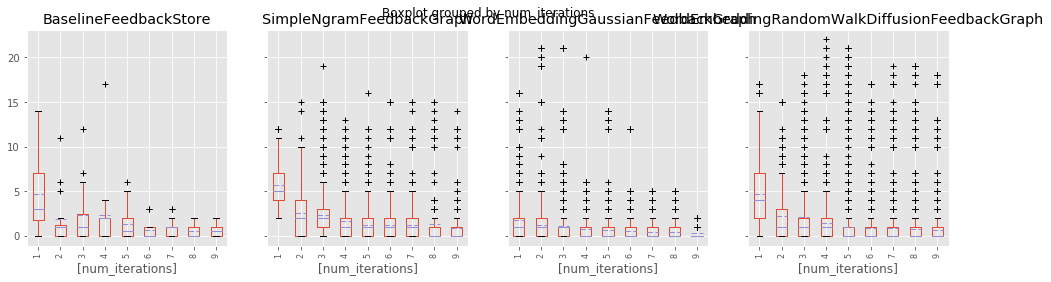

reject_new
num_iterations


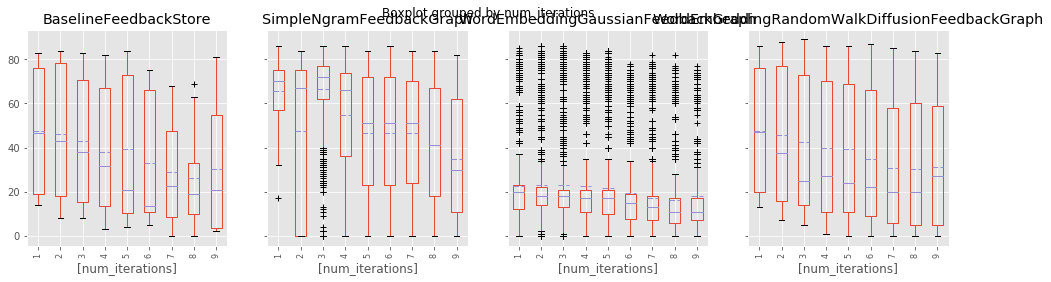

accept
num_iterations


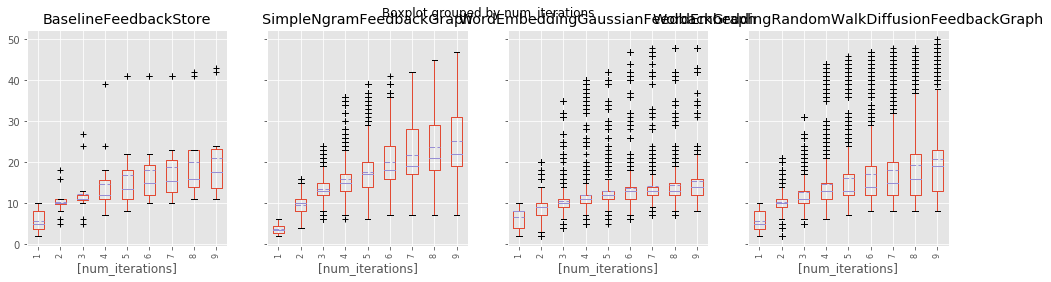

reject
num_iterations


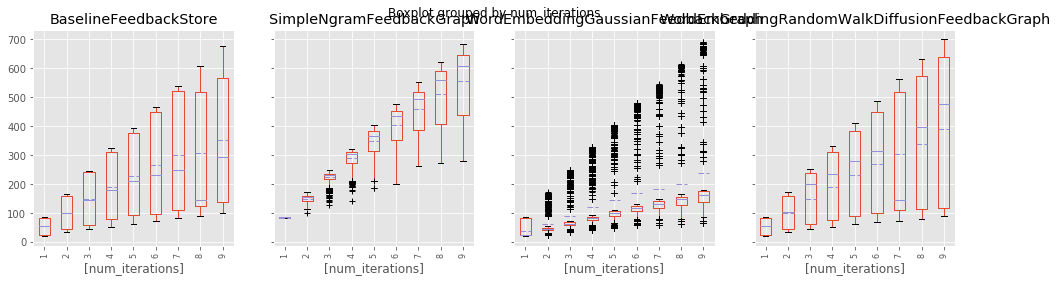

In [91]:
indep_vars = ["num_iterations"] 
grouping_var = "classtype"

dep_vars = [ 'accept_new', "reject_new", "accept", "reject"]

cols = ["parent"]
cols.extend(indep_vars)
cols.append(grouping_var)
cols.extend(dep_vars)

if "ref_summary" not in cols:
    cols.append("ref_summary")


topic1 = data.loc[:,cols]

for dep in dep_vars:
    for indep in indep_vars:
        print dep
        print indep
        myplot(topic1, indep, dep, groupby=grouping_var, save=True, layout=(1,4), figsize=(16,4), prefix="feeback-over-time")

In [ ]:
data = df

In [ ]:
indep_vars = ["num_iterations"] 
grouping_var = "phrase_type"

dep_vars = [ 'accept_new', "reject_new", "accept", "reject"]

cols = []
cols.extend(indep_vars)
cols.append(grouping_var)
cols.extend(dep_vars)

if "ref_summary" not in cols:
    cols.append("ref_summary")


topic1 = data.loc[:,cols]

for dep in dep_vars:
    for indep in indep_vars:
        print dep
        print indep
        myplot(topic1, indep, dep, groupby=grouping_var, save=True, layout=(1,4), figsize=(16,4), prefix="feeback-over-time-by-concept-type")

In [ ]:
topic1.columns

In [ ]:
[1,2,3] + [4] + [2,3,4]

In [ ]:
indep_vars = ["num_iterations"] 
grouping_var = "phrase_type"

dep_vars = [ 'accept_new', "reject_new", "accept", "reject"]

cols = list(set(indep_vars +  [grouping_var] + dep_vars + ["ref_summary"]))

topic1 = data.loc[:,cols]

for dep in dep_vars:
    for indep in indep_vars:
        print dep
        print indep
        myplot(topic1, indep, dep, groupby=grouping_var, save=True, layout=(1,4), figsize=(16,4), prefix="feeback-over-time-by-concept-type")

In [ ]:
data=df

In [ ]:
#data = df.sample(20000)

In [ ]:
data.groupby("cfg").count()

In [ ]:
data.groupby("run_id").count()

In [ ]:
key = lambda x: x.num_iterations

In [ ]:
d = data.loc[:,["run_id","accept","num_iterations"]].groupby("num_iterations")
d = d.head(20)

In [ ]:
plt.close()
d.plot()
plt.show()

In [ ]:
ax = None
cm = plt.get_cmap("Vega10")
for idx, (name, group) in enumerate(data.groupby("num_iterations")):
    print idx, name
    if idx > 20:
        break;
    ax = group.plot.scatter(x="num_iterations", y="ratio_r2_vs_r2bl", color=cm.colors[idx % 10], ax=ax);


plt.show()
#for i in range(1, len(locs)):
#    l = locs[i]
#    c = plt.get_cmap("Vega10").colors[i];
#    ax = data.loc[l].plot.scatter(x=x, y=y, color=c, ax=ax);
#plt.show()

In [ ]:
42 %3

Comparing the different classtypes against each other
===

In [ ]:
description = df.groupby(["ref_summary", "classtype"]).agg([len, np.min, np.mean, np.max]).loc[:,["r2", "ub_r2", "accept","ratio_r2_vs_r2bl"]]

In [ ]:
print description.to_latex(float_format='{0:.3f}'.format)

In [ ]:
description = df.groupby(["ref_summary", "classtype"]).agg([len, np.min, np.mean, np.max]).loc[:,["num_iterations","accept","reject","ub_r2","ratio_r2ub","r2","ratio_r2_vs_bl"]]

In [ ]:
print description.to_csv()

Best config, first try
====

best configuration as per agreement between all summaries of same config

we group by configuration, and then use the average ratio_ub2 score as performance measure.

In [ ]:
myf = df

In [ ]:
myf.info()

In [ ]:
# use the highest iteration only
myf = myf.sort_values(by="num_iterations", ascending= False).drop_duplicates(["cfg", "classtype", "ref_summary","oracle","embeddings", "phrase_type"])

In [ ]:
len(myf)

In [ ]:
 myf.loc[myf.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].groupby(["phrase_type", "oracle","cfg"]).mean().loc[:,["r2", "ratio_r2ub", "r2bl"," ub_r2","ratio_r2_vs_r2bl", "num_iterations"]].sort_values(by="ratio_r2ub", ascending=False)

In [ ]:
myf.loc[myf.cfg.str.contains('"mass_reject": -1.0, "iterations_accept": 1024, "propagation_abort_threshold": 0.25, "mass_accept": 1.0, "cut_off_threshold": 0.6, "type": "WordEmbeddingRandomWalkDiffusionFeedbackGraph", "iterations_reject": 200')].groupby("ref_summary").mean().sort_values("ratio_r2_vs_r2bl", ascending=False)

In [ ]:
myf.loc[myf.cfg.str.contains('"mass_reject": 0.0, "iterations_accept": 128, "mass_accept": 4.0, "cutoff_threshold": 0.6, "type": "WordEmbeddingGaussianFeedbackGraph", "iterations_reject": 16')].groupby("ref_summary").mean().sort_values("ratio_r2_vs_r2bl", ascending=False)

In [ ]:
df.iloc[170774]

In [ ]:
myf = df.loc[:,["cfg", "ref_summary","num_iterations"]].drop_duplicates(["cfg", "ref_summary","num_iterations"])


In [ ]:
myf=df.loc[df.classtype.str.contains("WordEmbeddingGaussianFeedbackGraph")].loc[df.cutoff_threshold >= 0.998].loc[df.ref_summary.str.contains("u'D31043.M.100.T")].loc[df.oracle.str.contains("active_learning")]

In [ ]:
len(myf)

In [ ]:
group_merge = myf.groupby(["cfg", "ref_summary"]).num_iterations.apply(np.max).reset_index().merge(myf, on=["cfg","ref_summary", "num_iterations"])
%timeit myf.groupby(["cfg", "ref_summary"]).num_iterations.apply(np.max).reset_index().merge(myf, on=["cfg","ref_summary", "num_iterations"])

In [ ]:
sort_drop=myf.sort_values(by=["cfg", "ref_summary","num_iterations"], ascending= [True, True, False]).drop_duplicates(["cfg", "ref_summary"])
%timeit myf.sort_values(by=["cfg", "ref_summary","num_iterations"], ascending= [True, True, False]).drop_duplicates(["cfg", "ref_summary"])

In [ ]:
sort_drop2=myf.sort_values(by=["num_iterations"], ascending= [ False]).drop_duplicates(["cfg", "ref_summary"])
%timeit myf.sort_values(by=["num_iterations"], ascending= [False]).drop_duplicates(["cfg", "ref_summary"])

In [ ]:
group_merge.info()

In [ ]:
sort_drop2.info()

In [ ]:
x = pd.merge(sort_drop2,sort_drop, how="inner", on=["cfg", "ref_summary","num_iterations"])

In [ ]:
x.info()

In [ ]:
x.dropna(inplace=True)

In [ ]:
x.info()

In [ ]:
x.drop_duplicates(["cfg", "ref_summary"])

In [ ]:
f2 = iteration_indexes.sample(2000)

In [ ]:
iteration_indexes

In [ ]:
f2.info()

In [ ]:
myf.iloc[6845]

In [ ]:
myf.loc[myf.cfg ]

In [ ]:
myf = df.sample(2000)


# throw away uninteresting columns
baseline_scores = myf.loc[baselines].loc[:,["ref_summary","num_iterations","accept", "reject","r2"]]

# rename important columns
baseline_scores.rename(columns={"r2":"r2bl", "accept": "acceptbl", "reject":"rejectbl"}, inplace=True)
# make sure, we have everything in there only once.
baseline_scores= baseline_scores.drop_duplicates(["ref_summary","num_iterations"])
baseline_scores= baseline_scores.loc[baseline_scores.acceptbl > 0].loc[baseline_scores.rejectbl > 0]

In [ ]:
dep_var = "ratio_r2ub"

In [ ]:
df.groupby(["ref_summary", "classtype"]).max().loc[:,["r2", "ratio_r2ub","ratio_r2_vs_r2bl", "accept"]]

In [ ]:
top = df.loc[df["ratio_r2_vs_r2bl"]>1.0].groupby(["cfg","ref_summary"]).max().sort_values("ratio_r2_vs_r2bl", ascending=False).loc[:,["r2", "ratio_r2ub","ratio_r2_vs_r2bl", "accept"]]

In [ ]:
top

In [ ]:
dep_vars.append("cfg")

In [ ]:
dep_vars = dep_vars[:-1]

In [ ]:
dep_var

In [ ]:
top.head(20)

In [ ]:
cfg_of_winner = top.reset_index().iloc[0].cfg
print cfg_of_winner
data = df.loc[df.cfg.str.contains(cfg_of_winner)]

indep_vars = ["num_iterations","iterations_accept", "propagation_abort_threshold"] 
grouping_vars = ["num_iterations"]
dep_vars = [ 'accept_new', "reject_new", "accept", "reject","ratio_r2ub", "ratio_r2_vs_r2bl","r2"]
default = ["classtype","ratio_r2ub", "ratio_r2_vs_r2bl", "r2", "ref_summary", "accept", "reject", "total_feedback","num_iterations","run_id"]
cols = list(set(indep_vars +  grouping_vars + dep_vars + default))
print cols

topic1 = data.loc[:,cols]

In [ ]:
topic1

In [ ]:
for dep in dep_vars:
    for indep in indep_vars:
        for group in grouping_vars:
            if dep == indep or dep == group or indep == dep or indep == group:
                continue
            print dep, indep, group
            myplot(topic1, indep, dep, groupby=group, save=False, figsize=(16,4), prefix="feeback-over-time-by-concept-type")

In [ ]:
cfg_of_winner = top.reset_index().iloc[1].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), cols]

In [ ]:
cfg_of_winner = top.reset_index().iloc[2].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), cols]

In [ ]:
cfg_of_winner = top.reset_index().iloc[3].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), cols]

In [ ]:
cfg_of_winner = top.reset_index().iloc[4].cfg
print cfg_of_winner
df.loc[df.cfg.str.contains(cfg_of_winner), cols]

Configs with 8 results
====

best configuration as per agreement between all summaries of same config

we group by configuration, and then use the average ratio_ub2 score as performance measure.

In [ ]:
top = df.groupby("cfg").count().sort_values(dep_var, ascending=False).reset_index().loc[:,["cfg", "accept"]]

In [ ]:
top=top.rename(columns={"accept": "num_results"})

In [ ]:
pd.merge(df, top, on="cfg")["num_results"]

Block 1: BaselineFeedbackStore
---

Hyperparameter search has no parameters, => 4 - 8 results are all to get (depending whether one or two topics are used)

In [ ]:
selected_classtype = "BaselineFeedbackStore"

In [ ]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [ ]:
#indep_var = [ "multiplier_accept","multiplier_reject", "window_size"]

No independent variables, therefore no configurations to compare against each other.
There should be `4` resp. `8` rows in the dataset

In [ ]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [ ]:
len(data)

In [ ]:
data.columns

In [ ]:
print(data.loc[:, [u'ref_summary',"classtype","phrase_type","r1","r2","r4",]].to_latex(index=False,float_format='{0:.3f}'.format))

In [ ]:
print(data.loc[:, [u'ref_summary',"classtype","phrase_type","ub_r1", 'ub_r2', 'ub_r4',]].to_latex(index=False,float_format='{0:.3f}'.format))

In [ ]:
# BaselineFeedbackStore is something special, as it doesnt have parameters:

In [ ]:
delta2 = data.loc[:,[ dep_var, "ref_summary"]]

delta2.boxplot(figsize=(10,4), showmeans=True, meanline=True, sym="+", vert=True)

delta2.groupby("ref_summary").boxplot(figsize=(16,4), layout=(2,4), fontsize="8", showmeans=True, meanline=True, sym="+", vert=True)
plt.savefig(path.join(basepath, "%s-%s-%s-per-summary-%s.pdf" % ("boxplot", selected_classtype, dep_var, "ref_summary")))

plt.show()
plt.close()
#indep_var = ["ref_summary"]

Block 2: SimpleNgramFeedbackGraph
---

In [ ]:
selected_classtype = "SimpleNgramFeedbackGraph"

This feedback store has three parameters.
The following combinations are tested:

In [ ]:
indep_var = [ "multiplier_accept","multiplier_reject", "window_size"]

                window_size = [2, 3, 4, 5]
                factor_rejects = [1, 0, 0.05, 0.25, 0.5, 2, 4,8]
                factor_accepts = [1, 0, 0.05, 0.25, 0.5, 2, 4,8]

As a result, there are `4*7*7 = 196` combinations per topic. In total, there should be `196 * 4` resp. `196 * 8` rows in the dataset

In [ ]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [ ]:
len(data)

In [ ]:
selected_classtype

In [ ]:
for col in indep_var:
    bp(data, col, dep_var,classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="groupby", classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="line", classtype=selected_classtype)


Block 3: WordEmbeddingGaussianFeedbackGraph
---

In [ ]:
selected_classtype = "WordEmbeddingGaussianFeedbackGraph"

In [ ]:
# indep_var = [ "mass_accept","mass_reject","type","iterations_accept","iterations_reject", "cutoff_threshold"]
# due to a bug, the cutoff_threshold is NOT stored in the result file, we therefore have to exclude it.
indep_var = [ "mass_accept","mass_reject","type","iterations_accept","iterations_reject"]

                mass_reject = [4.0, 1.0, 0.0, -1.0, -4.0]
                mass_accept = [4.0, 1.0, 0.0, -1.0, -4.0]
                iterations_accept = [16, 128, 1024]
                iterations_reject = [2, 4, 8, 16, 64]
                cut_off_threshold = [0.998, 0.98, 0.9, 0.6, 0.4]

Results in 1875 combinations per topic.

In [ ]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [ ]:
len(data)

In [ ]:
for col in indep_var:
    bp(data, col, dep_var,classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="groupby", classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="line", classtype=selected_classtype)


Block 4: WordEmbeddingRandomWalkDiffusionFeedbackGraph
---

In [ ]:
selected_classtype = "WordEmbeddingRandomWalkDiffusionFeedbackGraph"

This feedback store has 6 parameters.
The following combinations are tested:

In [ ]:
indep_var = [ "mass_reject", "mass_accept", \
             "iterations_accept", "iterations_reject",\
             "propagation_abort_threshold", \
             "cutoff_threshold"]

mass_reject = [4.0, 1.0, 0.0, -1.0, -4.0]
                mass_accept = [4.0, 1.0, 0.0, -1.0, -4.0]
                iterations_accept = [128, 1024, 10000]
                iterations_reject = [64, 200, 5000]
                cut_off_threshold = [0.998, 0.98, 0.9, 0.6, 0.4]
                propagation_abort_threshold = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]


As a result, there are `5*5*3*3*5*6 = 6750` combinations per topic. In total, there should be `6750 * 4` resp. `6750 * 8` rows in the dataset

In [ ]:
data = df.loc[df.classtype.str.contains(selected_classtype)]

In [ ]:
len(data)

In [ ]:
for col in indep_var:
    bp(data, col, dep_var,classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="groupby", classtype=selected_classtype)

    
for col in indep_var:
    bp(data, col, dep_var, grouping="line", classtype=selected_classtype)


Some overall basic correlation tests
===

In [ ]:
df.corr(method="spearman")


In [ ]:
df.corr(method="pearson").to_csv(path.join(basepath, "correlation-analysis-pearson-overall.csv"))


In [ ]:
df.groupby("classtype").corr(method="pearson").to_csv(path.join(basepath, "correlation-analysis-pearson-per-classtype.csv"))


In [ ]:
cols = list(df.columns)

In [ ]:
cols = list(set(cols) - set(['accept', 'num_iterations', 'r1', 'r2', 'r4', 'reject', 'total_feedback', 'ub_r1', 'ub_r2', 'ub_r4', 'acceptbl', 'rejectbl', 'r2bl', 'delta_r2bl_r2', 'ratio_r2bl_r2', 'delta_r2ub']))

In [ ]:
r= df.loc[:,cols].groupby(["classtype", "mass_accept"]).corr(method="pearson")

r.to_csv(path.join(basepath, "correlation-analysis-pearson-per-classtype-and-mass_accept.csv"))
r

Top result analysis
===

From the best performing summaries, are there certain configurations that appear more often than others?

in the first run, we use the `WordEmbeddingRandomWalkDiffusionFeedbackGraph`

In [ ]:
selected_classtype = "WordEmbeddingRandomWalkDiffusionFeedbackGraph"

In [ ]:
data = df.loc[df.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")]

In [ ]:
d = data.loc[df.ratio_r2ub > 1.0, ["classtype","cutoff_threshold","iterations_accept","iterations_reject","mass_accept","mass_reject","propagation_abort_threshold", "ref_summary","ratio_r2ub"]]

In [ ]:
g = d.groupby("ref_summary")
for grp in g.groups:
    print grp, g.get_group(grp).count()
    
    g.get_group(grp)["propagation_abort_threshold"].hist()
    plt.show()


In [ ]:
for col in d.columns:
    if col is not dep_var:
        bp(d, col, dep_var, grouping="line")

In [ ]:
for col in indep_var:
    bp(data, col, dep_var, grouping="line")
    

In [ ]:
len(data)

In [ ]:
scatterplot(data,x="r2",y="accept", locs= [data.ref_summary.str.contains("D30044.M.100.T.B"), data.ref_summary.str.contains("D30044.M.100.T.C"), data.ref_summary.str.contains("D30044.M.100.T.D"), data.ref_summary.str.contains("D30044.M.100.T.G")])

In [ ]:
scatterplot(data,x="total_feedback",y="ratio_r2ub", locs= [data.classtype.str.contains("SimpleNgramFeedbackGraph"),data.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph"),data.classtype.str.contains("WordEmbeddingRandomWalkDiffusionFeedbackGraph")])

In [ ]:
df.ref_summary.str.contains("D30044.M.100.T.B")

In [ ]:
type(df.ref_summary.str.contains("D30044.M.100.T.D"))


In [ ]:
len(df)

In [ ]:
data.classtype.str.contains("BaselineFeedbackStore")

In [ ]:
data.loc[data.classtype.str.contains("SimpleNgramFeedbackGraph")].describe()

Upper Bound and Baseline
===

In [111]:
last_baseline_iteration_score=baseline_scores.drop_duplicates(["ref_summary","num_iterations", "phrase_type"])

In [112]:
last_baseline_iteration_score.sort_values("num_iterations", ascending=False).drop_duplicates(["ref_summary","phrase_type"]).sort_values("ref_summary")

,ref_summary,num_iterations,accept,reject,r1,r2,r4,phrase_type
192507,[u'D31043.M.100.T.D'],9,15,108,0.52885,0.30097,0.27221,parse
46255,[u'D31043.M.100.T.D'],9,42,425,0.48077,0.28155,0.20132,None
190208,[u'D31043.M.100.T.F'],9,19,550,0.48544,0.15686,0.19664,None
74661,[u'D31043.M.100.T.F'],9,14,143,0.38835,0.06863,0.12269,parse
385341,[u'D31043.M.100.T.G'],9,21,658,0.39806,0.07843,0.12979,None
175907,[u'D31043.M.100.T.G'],9,12,99,0.51456,0.06863,0.23063,parse
334582,[u'D31043.M.100.T.H'],9,13,147,0.39048,0.07692,0.11628,parse
544,[u'D31043.M.100.T.H'],9,23,614,0.37143,0.09615,0.12994,None


In [114]:
print last_baseline_iteration_score.sort_values("num_iterations", ascending=False).drop_duplicates(["ref_summary","phrase_type"]).sort_values("ref_summary").to_csv()

,ref_summary,num_iterations,accept,reject,r1,r2,r4,phrase_type
192507,[u'D31043.M.100.T.D'],9,15,108,0.52885,0.30097,0.27221,parse
46255,[u'D31043.M.100.T.D'],9,42,425,0.48077,0.28155,0.20132,None
190208,[u'D31043.M.100.T.F'],9,19,550,0.48544,0.15686,0.19664,None
74661,[u'D31043.M.100.T.F'],9,14,143,0.38835,0.06863,0.12269,parse
385341,[u'D31043.M.100.T.G'],9,21,658,0.39806,0.07843,0.12979,None
175907,[u'D31043.M.100.T.G'],9,12,99,0.51456,0.06863,0.23063,parse
334582,[u'D31043.M.100.T.H'],9,13,147,0.39048,0.07692,0.11628,parse
544,[u'D31043.M.100.T.H'],9,23,614,0.37143,0.09615,0.12994,None



In [51]:
ub = df.drop_duplicates(["ref_summary", "phrase_type"])

In [53]:
ub.columns

Index([u'accept', u'accept_new', u'cfg', u'classtype', u'cutoff_threshold',
       u'embeddings', u'feedback_new', u'iterations_accept',
       u'iterations_reject', u'mass_accept', u'mass_reject',
       u'max_iteration_count', u'multiplier_accept', u'multiplier_reject',
       u'num_iterations', u'oracle', u'parent', u'phrase_type',
       u'propagation_abort_threshold', u'r1', u'r2', u'r4', u'ref_summary',
       u'reject', u'reject_new', u'run_id', u'size', u'total_feedback',
       u'ub_r1', u'ub_r2', u'ub_r4', u'window_size', u'acceptbl', u'rejectbl',
       u'r2bl', u'delta_r2bl_r2', u'ratio_r2_vs_r2bl', u'delta_r2ub',
       u'ratio_r2ub', u'ratio_r2ub_vs_feedback'],
      dtype='object')

In [95]:
ub.loc[:,["ref_summary","r2bl", "r1bl", "r4bl", u'ub_r1',"ub_r2","ub_r4","phrase_type"]].sort_values("ref_summary")

,ref_summary,r2bl,r1bl,r4bl,ub_r1,ub_r2,ub_r4,phrase_type
60718,[u'D31043.M.100.T.D'],0.18447,NaN,NaN,0.58654,0.42718,0.32112,None
60719,[u'D31043.M.100.T.D'],0.18447,NaN,NaN,0.58654,0.42718,0.32112,parse
150059,[u'D31043.M.100.T.F'],0.11765,NaN,NaN,0.52427,0.19608,0.20187,None
150061,[u'D31043.M.100.T.F'],0.11765,NaN,NaN,0.52427,0.19608,0.20187,parse
0,[u'D31043.M.100.T.G'],0.08824,NaN,NaN,0.41748,0.13725,0.16265,None
2,[u'D31043.M.100.T.G'],0.08824,NaN,NaN,0.41748,0.13725,0.16265,parse
261326,[u'D31043.M.100.T.H'],0.07692,NaN,NaN,0.45714,0.15385,0.17901,None
261328,[u'D31043.M.100.T.H'],0.07692,NaN,NaN,0.45714,0.15385,0.17901,parse


In [92]:
print ub.loc[:,["r2bl", u'ub_r1',"ub_r2","ub_r4","phrase_type","ref_summary"]].sort_values("ref_summary").to_latex()

\begin{tabular}{lrrrrll}
\toprule
{} &     r2bl &    ub\_r1 &    ub\_r2 &    ub\_r4 & phrase\_type &            ref\_summary \\
\midrule
60718  &  0.18447 &  0.58654 &  0.42718 &  0.32112 &        None &  [u'D31043.M.100.T.D'] \\
60719  &  0.18447 &  0.58654 &  0.42718 &  0.32112 &       parse &  [u'D31043.M.100.T.D'] \\
150059 &  0.11765 &  0.52427 &  0.19608 &  0.20187 &        None &  [u'D31043.M.100.T.F'] \\
150061 &  0.11765 &  0.52427 &  0.19608 &  0.20187 &       parse &  [u'D31043.M.100.T.F'] \\
0      &  0.08824 &  0.41748 &  0.13725 &  0.16265 &        None &  [u'D31043.M.100.T.G'] \\
2      &  0.08824 &  0.41748 &  0.13725 &  0.16265 &       parse &  [u'D31043.M.100.T.G'] \\
261326 &  0.07692 &  0.45714 &  0.15385 &  0.17901 &        None &  [u'D31043.M.100.T.H'] \\
261328 &  0.07692 &  0.45714 &  0.15385 &  0.17901 &       parse &  [u'D31043.M.100.T.H'] \\
\bottomrule
\end{tabular}

